## Posterior Estimation for Geometric Brownian Motion

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bayesflow as bf
import keras
import os
import jax
from Motion import Motion

INFO:2025-12-12 10:36:07,795:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:bayesflow:Using backend 'jax'


Our goal here is to perform SBI on a geometric brownian motion simulator that produces 3 correlated motions with freed drift parameters and a free full covariance matrix. To start, we import all our relevant packages, which includes bayesflow, jax, and the Motion library which will be used for the simulator.

## Defining Our Simulator

In [2]:
motion = Motion(simulator="geom", parameters="fc", with_prior=True)
simulator = bf.simulators.make_simulator([lambda : motion()])

To start, we create a simulator using our Motion library to define a geometric brownian motion with the full covariance matrix freed (as opposed to having a diagonal or spherical covariance matrix, which are also options). Then we turn this into a Bayesflow simulator by passing it as a lambda function. This is to accomodate the fact that our "motion" object is called as a functor whenever we want to perform a simulation, while make_simulator() accepts a function.

## Creating a Summary Network

In [3]:
class GRU(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.gru = keras.layers.GRU(64, dropout=0.1)
        self.summary_stats = keras.layers.Dense(32)

    def call(self, time_series, **kwargs):
        summary = self.gru(time_series, training=kwargs.get("stage") == "training")
        summary = self.summary_stats(summary)
        return summary

We define a custom GRU summary network inheriting from Bayesflow's networks.SummaryNetwork, which allows us to use a custom summary network with our workflow. This is to create the correct dimensionality for our data and account for the time-series nature of it.

## Putting Things Together

In [4]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series("motion")
    .concatenate(["b1", "b2", "b3", "v1", "v2", "v3", "m21", "m31", "m32"], into="inference_variables")
    .rename("motion", "summary_variables")
)

summary_net = GRU(dropout=0.1)

inference_net = bf.networks.FlowMatching(dropout=0.1)

workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net,
    checkpoint_path="motion_workflow/"
)

Now, we define our adapter, where we define which variables are our inference variables, which variables are our summary variables, and perform any other transformations to our data we think are appropriate. We also define our inference net, which in this case will be a FlowMatching inference net, as this should work best for our time series data. Finally, we combine all of our previous work together into a workflow.

## Fitting Our Model
Now, we just need to train our model on simulated data, and hopefully get a model that produces informative priors

In [5]:
train = workflow.simulate(8000)
validation = workflow.simulate(300)

history = workflow.fit_offline(data=train,
                               epochs=100,
                               batch_size=32,
                               validation_data=validation)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5.7408 - val_loss: 2.1623
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.3083 - val_loss: 1.8722
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.8727 - val_loss: 1.6253
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.6669 - val_loss: 1.4891
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.5700 - val_loss: 1.5260
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.5296 - val_loss: 1.4444
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.5126 - val_loss: 1.5499
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.4768 - val_loss: 1.4533
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.4613 - val_loss: 1.4714
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.4372 - val_loss: 1.3554
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.4229 - val_loss: 1.4651
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━━━

## Plotting Loss
While it is not very informative of the actual quality of the model, we still check the loss trajectory of our model to confirm that it was indeed learning something over the course of our training. If this doesn't converge, that is not a very good sign.

[]

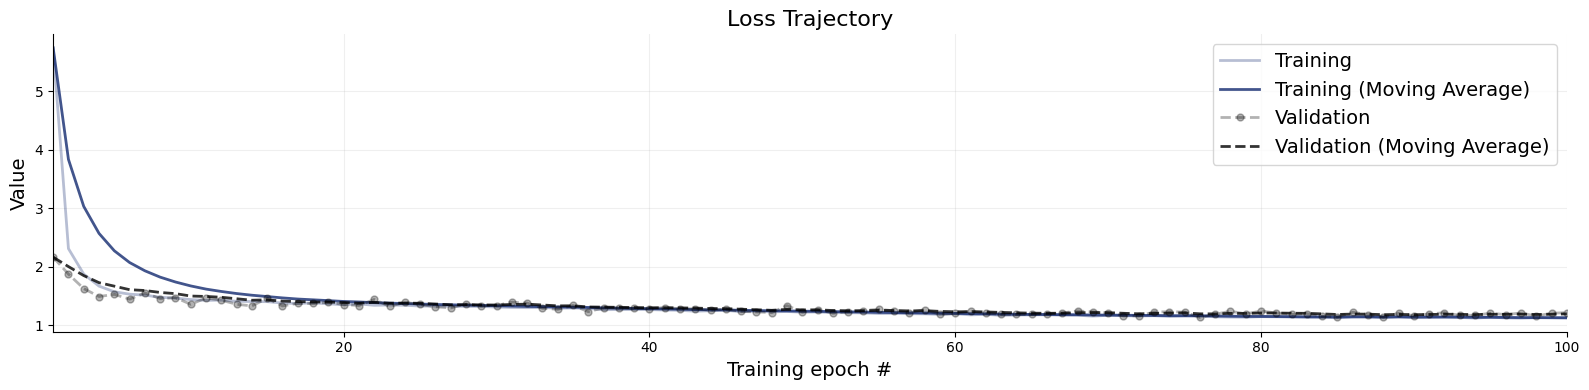

In [6]:
f = bf.diagnostics.plots.loss(history)
plt.plot()

## Checking Recoveries
Now for the useful part! We can check how well our model recovers the freed parameters by plotting our posteriors against the inputted priors for a number of samples. What we want to see here is a fairly linear trend, or we can just look at our r value to see how well our posterior is correlated with the inputted priors

Running simulations
Sampling
Making plots


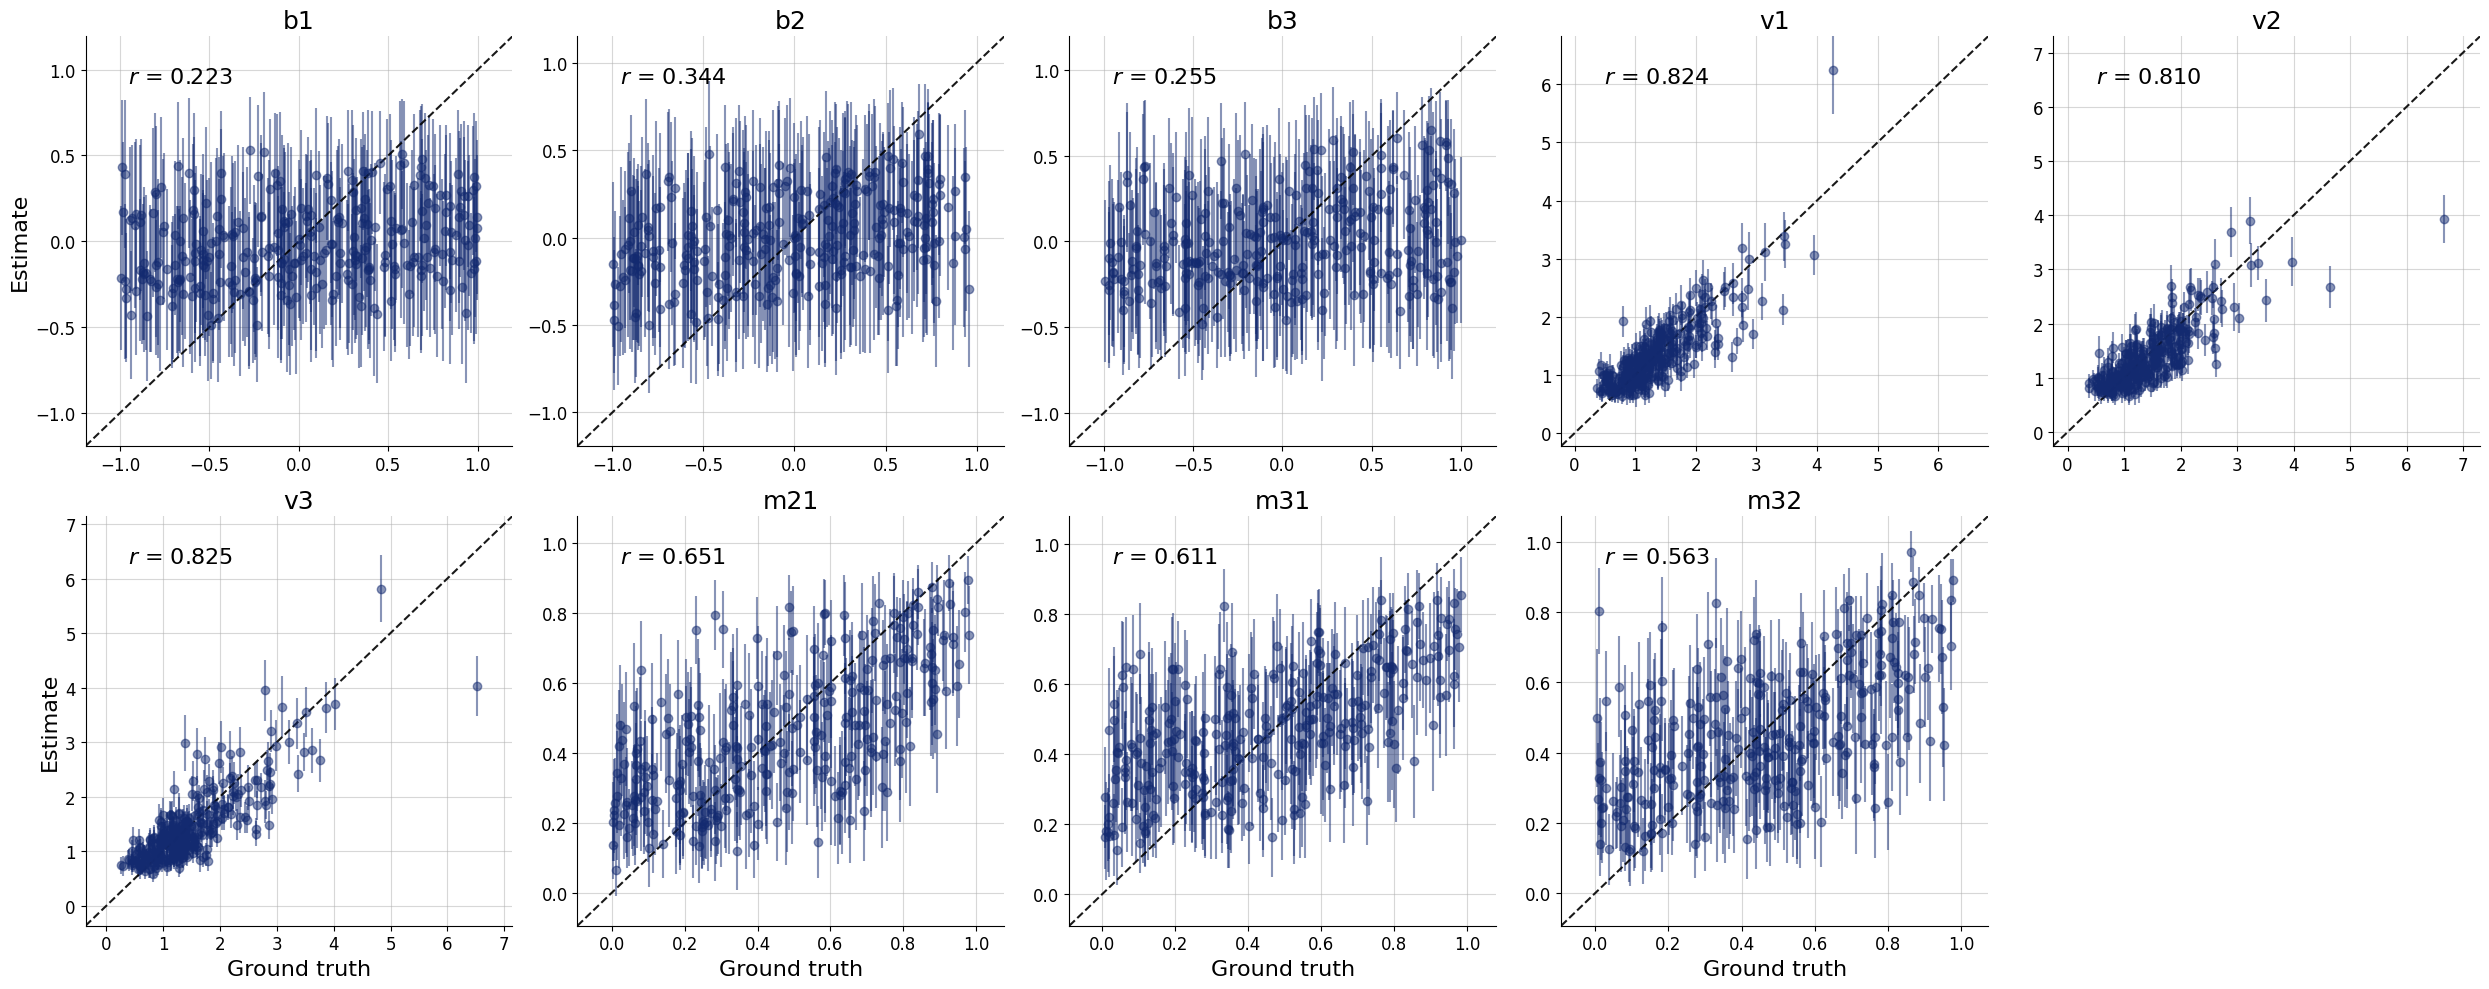

In [7]:
num_datasets = 300
num_samples = 1000

# Simulate 300 scenarios
print("Running simulations")
test_sims = workflow.simulate(num_datasets)

# Obtain num_samples posterior samples per scenario
print("Sampling")
samples = workflow.sample(conditions=test_sims, num_samples=num_samples)

print("Making plots")
f = bf.diagnostics.plots.recovery(samples, test_sims)

plt.savefig("overfit_recoveries.png")

## Posterior Checks
To see how well our model can actually perform, we can take a specific sample from our prior distributions, generate data, perform inference on it, and then see how well our model constructs a posterior distribution for that given sample. In this case, we will focus on the variance parameters since those have the best recoveries, and we will just use one of the samples we generated in the previous cell to test

[]

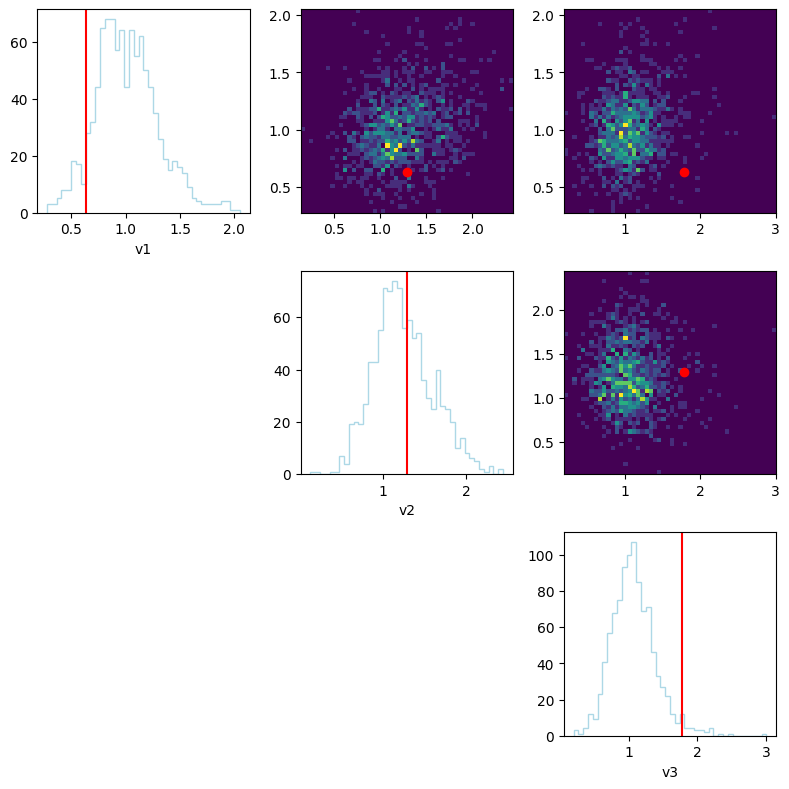

In [8]:
labels = ["v1", "v2", "v3"]

truths = np.asarray([test_sims[labels[0]][0].item(),
                     test_sims[labels[1]][0].item(),
                     test_sims[labels[2]][0].item()])

out_samples = np.asarray([samples[labels[0]][0].flatten(),
                          samples[labels[1]][0].flatten(),
                          samples[labels[2]][0].flatten()]).T

d = out_samples.shape[1]
fig, axes = plt.subplots(d, d, figsize=(8, 8))

for i in range(d):
    for j in range(d):
        ax = axes[i, j]
        if i == j:
            ax.set_facecolor("white")  # set background blue
            ax.hist(out_samples[:, i], bins=40, histtype="step", color="lightblue")
            ax.axvline(truths[i], color="red")
            ax.set_xlabel(labels[i])
        elif i < j:
            ax.set_facecolor("midnightblue")  # set background blue
            h = ax.hist2d(out_samples[:, j], out_samples[:, i],
                          bins=50, cmap="viridis")
            ax.plot(truths[j], truths[i], "o", color="red")
        else:
            ax.axis("off")

plt.tight_layout()

plt.plot()